# 데이터 준비

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [84]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], parse_dates=[3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [397]:
data.isnull().sum()

UserId    0
ItemId    0
Rating    0
Time      0
dtype: int64

# Step1. 데이터 전처리

- 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.
- 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.
- ==> Session은 사용자의 일련의 웹 탐색 활동이 종료되기까지 1회 카운트 된다. 유저가 계정에 ID로 로그인한 여부와 관계없이 웹 탐색 활동의 시작과 종료를 기준으로 카운트되기 때문에, 정확히는 UserID로 집계되는 수치와 다르지만, 여기에서는 편의를 위해 SessionID와 UserID를 동일한 개념으로 두고 진행하겠다.

- 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.
- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 __'초단위 시간'__이 기재되어 있습니다.

### 1) 항목별 기본분석

In [207]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

유저 계정 6040개, 아이템 3706개

### 2) Session Length

In [208]:
# 각 계정(UserID 당)이 아이템(Item) 을 클릭한 횟수
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [209]:
# 유저가 클릭한 행위의 평균 카운트
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [210]:
# 유저가 클릭한 행위의 최소, 최대 카운트
session_length.min(), session_length.max()

(20, 2314)

In [211]:
session_length.quantile(0.999)

1343.181000000005

99.9%에 해당하는 유저의 클릭수(카운트)는 약 1343 이하

In [11]:
# 클릭수가 가장 많은 유저 행동 살펴보기
long_session_length = session_length[session_length==2314].index[0]
data[data['UserId']==long_session_length]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


99.9% 이외에 해당하는 가장 많은 클릭 수를 보유한 계정은 동시에 다른 아이템에 평점을 매기고 있음. ==> 평점 조작 의혹

In [12]:
# 시각화
# 클릭수 기준 하위 99.9%까지의 분포 누적합
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

클릭수 20 ~ 1323에 약 99.9% 분포

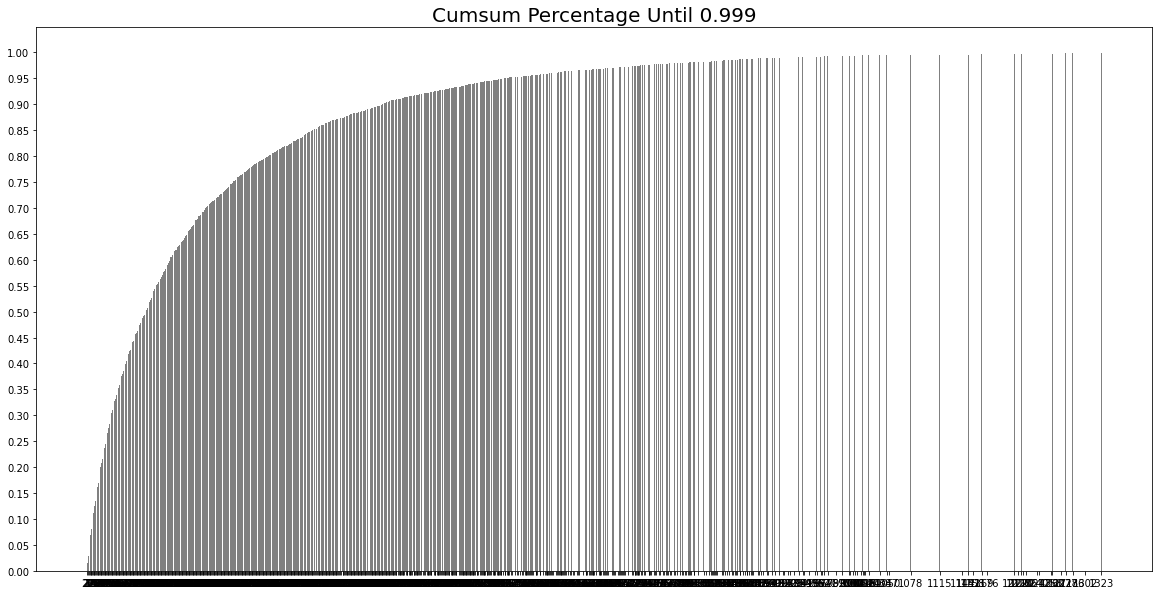

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='grey')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 3) Session Time

Unix Time으로 표기된 Time 칼럼(time stamp)을 datetime 객체로 변환

In [85]:
data['Time'] = data['Time'].apply(lambda x:dt.datetime.utcfromtimestamp(int(x)))

In [86]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [87]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

- 최근 소비 트렌드로 학습하는 것이 중요하므로 __최근 1개월의 데이터만 사용__
- 영화 콘텐츠 특성상 추천 기준을 다양하게 설정할 수 있다.
- 여기에서는 최신 영화를 기준으로 추천할 것이기 때문에 최근 1개월 데이터를 사용하겠다.

In [50]:
#month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
#data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다.
#data

In [7]:
data['UserId'].nunique()

6040

In [447]:
data.groupby('UserId').size()

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [448]:
data['ItemId'].nunique()

3706

In [449]:
data.groupby('ItemId').size()

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

### 4) Cleaning

- ①길이가 1인 세션은 제거
- ②너무 적게 클릭된 아이템도 제거

In [89]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        
        #data = cleanse_low_ratings(data, low_ratings)
        
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

#def cleanse_low_ratings(data: pd.DataFrame, low_ratings):
#    ratings_len = data.groupby('Rating').size()
#    ratings_use = ratings_len[ratings_len >= low_ratings].index
#    data = data[data['Rating'].isin(ratings_use)]
#    return data

In [90]:
session_len = data.groupby('UserId').size()
session_len

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [91]:
ratings_len = data.groupby('Rating').size()
ratings_len

Rating
1     56174
2    107557
3    261197
4    348971
5    226310
dtype: int64

동일 유저가 최소 2번 이상 클릭하고, 모든 유저의 클릭 중에서 적어도 4번 이상 클릭된 아이템 선별

In [92]:
data = cleanse_recursive(data, shortest=2, least_click=4) # , low_ratings=2
data.sort_values(by=['Rating'], axis=0)

,UserId,ItemId,Rating,Time
38953,264,266,1,2000-12-12 20:45:29
313596,1871,2527,1,2000-11-20 04:26:20
208047,1272,1721,1,2000-11-21 14:46:25
687851,4115,1994,1,2000-08-04 04:59:15
47595,319,344,1,2000-12-10 04:30:05
...,...,...,...,...
759989,4515,1197,5,2000-07-30 22:50:04
759996,4515,1262,5,2000-07-30 22:49:35
321497,1905,3089,5,2000-11-20 03:38:22
323078,1916,3089,5,2000-11-20 03:47:12


In [55]:
print(sum(data['Rating']==1), sum(data['Rating']==2), 
      sum(data['Rating']==3), sum(data['Rating']==4), sum(data['Rating']==5))

56093 107473 261087 348863 226275


In [93]:
data['UserId'].nunique()

6040

In [94]:
data.groupby('UserId').size()

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [471]:
data['ItemId'].nunique()

3461

In [472]:
data.groupby('ItemId').size()

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3461, dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999791 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   UserId  999791 non-null  int32         
 1   ItemId  999791 non-null  int32         
 2   Rating  999791 non-null  int32         
 3   Time    999791 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3)
memory usage: 26.7 MB


### 5) Train / Valid / Test split

##### -------------------------------------------------------------------

yoochoose-test.dat 데이터 확인

In [20]:
test = pd.read_csv(data_path / 'yoochoose-test.dat')

In [21]:
test.sort_values(by=['2014-04-07T17:13:46.713Z'], axis=0)

,5,2014-04-07T17:13:46.713Z,214530776,0
17414,23675,2014-04-01T03:00:08.250Z,214842345,0
102459,123545,2014-04-01T03:00:17.603Z,214717003,0
17415,23675,2014-04-01T03:00:31.643Z,214639372,0
29726,40525,2014-04-01T03:00:32.008Z,214684320,0
17416,23675,2014-04-01T03:00:44.712Z,214591470,0
...,...,...,...,...
8234196,11274485,2014-09-30T02:55:38.243Z,214859870,S
8076709,11539880,2014-09-30T02:58:36.151Z,214526083,2
8146305,11411890,2014-09-30T02:58:47.108Z,214696432,0
8106572,11471850,2014-09-30T02:59:10.846Z,214690127,S


- ratings.dat의 최근 1개월 데이터는 2003년에 해당한다. yoochoose-test 데이터는 2014년 데이터이다. LMS 노드에서는 yoochoose-clikcks.dat 데이터와 yoochoose-test.dat 데이터의 기간이 겹치기 때문에 준비된 test set을 사용하지 않고, yoochoose-clikcks.dat 데이터에서 train, valid, test 셋을 나누었다.
- 해당 노트북에서는 yoochoose-test.dat를 사용할 수 없으므로, ratings.dat에서 train, valid, test 셋을 만들어 사용한다.

##### -------------------------------------------------------------------

시간을 기준으로 train, validation, test set 나누기

In [95]:
data['Time'].min(), data['Time'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

In [96]:
data.sort_values(by=['Time'], axis=0)

,UserId,ItemId,Rating,Time
1000138,6040,858,4,2000-04-25 23:05:32
999873,6040,593,5,2000-04-25 23:05:54
1000153,6040,2384,4,2000-04-25 23:05:54
1000007,6040,1961,4,2000-04-25 23:06:17
1000192,6040,2019,5,2000-04-25 23:06:17
...,...,...,...,...
825793,4958,2399,1,2003-02-28 17:45:38
825438,4958,1407,5,2003-02-28 17:47:23
825731,4958,2634,3,2003-02-28 17:49:08
825724,4958,3264,4,2003-02-28 17:49:08


In [408]:
#pd.set_option('display.max_columns', 0)

#def split_by_date(data: pd.DataFrame, n_days: int):
#    final_time = data['Time'].max()
#    session_last_time = data.groupby('UserId')['Time'].max()
#    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
#    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

#    before_date = data[data['UserId'].isin(session_in_train)]
#    after_date = data[data['UserId'].isin(session_in_test)]
#    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
#    return before_date, after_date

In [409]:
#tr, test = split_by_date(data, n_days=1)
#tr, val = split_by_date(tr, n_days=1)

In [97]:
data_train = data[:699900]
data_val = data[699900:899900]
data_test = data[899900:]

In [98]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [99]:
stats_info(data_train, 'train')
stats_info(data_val, 'valid')
stats_info(data_test, 'test')

* train Set Stats Info
	 Events: 699900
	 Sessions: 4188
	 Items: 3460
	 First Time : 2000-08-03 18:05:41
	 Last Time : 2003-02-28 00:51:39

* valid Set Stats Info
	 Events: 200000
	 Sessions: 1256
	 Items: 3368
	 First Time : 2000-06-02 20:50:58
	 Last Time : 2003-02-28 17:49:50

* test Set Stats Info
	 Events: 99891
	 Sessions: 598
	 Items: 3180
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-02-28 13:12:12



In [100]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(data_train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

data_train = indexing(data_train, id2idx)
data_val = indexing(data_val, id2idx)
data_test = indexing(data_test, id2idx)

In [101]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

data_train.to_pickle(save_path / 'train.pkl')
data_val.to_pickle(save_path / 'valid.pkl')
data_test.to_pickle(save_path / 'test.pkl')

---------------------------------------------------------------------------

# Step2. 미니 배치 구성

- 데이터셋과 미니 배치를 구성
- Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성
- 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

### 1) SessionDataset

데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.
click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.
session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.

In [102]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each User IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [103]:
tr_dataset = SessionDataset(data_train)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [104]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 699829, 699896, 699900], dtype=int32)

In [105]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 4185, 4186, 4187])

### **2) SessionDataLoader

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
__iter__ 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
mask는 후에 RNN Cell State를 초기화 하는데 사용할 것입니다.

In [106]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [107]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [108]:
iter_ex = iter(tr_data_loader)

아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다.

In [109]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


# Step3. 모델 구성

### 1) Evaluation Metric

- Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.
- 이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다.
- 추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다. 따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.
- MRR은 정답 아이템이 나온 순번의 역수 값입니다. 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것입니다.

In [110]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 2) Model Architecture

In [111]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [112]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [113]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(data_train, data_val, data_test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [114]:
model = create_model(args)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(256, 1, 3460)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    526800    
_________________________________________________________________
dropout_5 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_5 (Dense)              (256, 3460)               176460    
Total params: 703,260
Trainable params: 703,260
Non-trainable params: 0
_________________________________________________________________


# Step4. 모델 학습

- 다양한 하이퍼파라미터를 변경해 보며 검증 
- 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

배치 사이즈나 epoch 등의 설정은 위의 args에서 관리하므로 진행전 값을 확인해 주세요.

In [115]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.

def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [40]:
train_model(model, args) #1

Train:   0%|          | 0/5435 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.94] 

	 - Recall@20 epoch 1: 0.181652
	 - MRR@20    epoch 1: 0.044997



Train:   0%|          | 0/5435 [00:00<?, ?it/s, accuracy=0.117, train_loss=5.4]   

	 - Recall@20 epoch 2: 0.253500
	 - MRR@20    epoch 2: 0.066444



Train:   0%|          | 0/5435 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.09]  

	 - Recall@20 epoch 3: 0.279291
	 - MRR@20    epoch 3: 0.075617



Train:   0%|          | 0/5435 [00:00<?, ?it/s, accuracy=0.117, train_loss=5.04]  

	 - Recall@20 epoch 4: 0.290000
	 - MRR@20    epoch 4: 0.080522



Evaluation:  89%|████████▉ | 1384/1552 [16:07<01:57,  1.43it/s]

	 - Recall@20 epoch 5: 0.295859
	 - MRR@20    epoch 5: 0.083569



In [77]:
train_model(model, args) #2

Train:   0%|          | 0/10870 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.01]

	 - Recall@20 epoch 1: 0.196372
	 - MRR@20    epoch 1: 0.046891



Train:   0%|          | 0/10870 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.63]

	 - Recall@20 epoch 2: 0.250588
	 - MRR@20    epoch 2: 0.064117



Train:   0%|          | 0/10870 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.33]

	 - Recall@20 epoch 3: 0.269041
	 - MRR@20    epoch 3: 0.072001



Train:   0%|          | 0/10870 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.56]

	 - Recall@20 epoch 4: 0.279412
	 - MRR@20    epoch 4: 0.076491



Evaluation:  95%|█████████▌| 2950/3105 [18:05<00:57,  2.72it/s]

	 - Recall@20 epoch 5: 0.284195
	 - MRR@20    epoch 5: 0.078724



In [116]:
train_model(model, args) #3

Train:   0%|          | 0/2717 [00:00<?, ?it/s, accuracy=0.043, train_loss=6.48]  

	 - Recall@20 epoch 1: 0.138507
	 - MRR@20    epoch 1: 0.032924



Train:   0%|          | 0/2717 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.87] 

	 - Recall@20 epoch 2: 0.241046
	 - MRR@20    epoch 2: 0.060994



Train:   0%|          | 0/2717 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.65] 

	 - Recall@20 epoch 3: 0.271300
	 - MRR@20    epoch 3: 0.071549



Train:   0%|          | 0/2717 [00:00<?, ?it/s, accuracy=0.082, train_loss=5.52]  

	 - Recall@20 epoch 4: 0.285466
	 - MRR@20    epoch 4: 0.077590



Evaluation:  76%|███████▋  | 592/776 [13:27<04:10,  1.36s/it]

	 - Recall@20 epoch 5: 0.293886
	 - MRR@20    epoch 5: 0.081812



# Step5. 모델 테스트

- 미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인

In [41]:
#1
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, data_test)

Evaluation:  77%|███████▋  | 599/775 [06:58<02:02,  1.43it/s]

	 - Recall@20: 0.292897
	 - MRR@20: 0.079549



In [78]:
#2
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, data_test)

Evaluation:  88%|████████▊ | 1361/1551 [08:21<01:10,  2.71it/s]

	 - Recall@20: 0.278954
	 - MRR@20: 0.075294



In [117]:
#3
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, data_test)

Evaluation:  55%|█████▍    | 212/387 [04:48<03:58,  1.36s/it]

	 - Recall@20: 0.299215
	 - MRR@20: 0.082378



# 회고

- IndexError: index 15 is out of bounds for axis 0 with size 15
- 데이터 양을 조절하고, batch_size를 조정해도 모델 학습 부분에서 계속 위와 같은 에러가 났다.
- 구글링을 해 본 결과, 아마도 Session data loader 부분에서 인덱스 에러가 나는 것 같다.
- 모델 학습 진행을 위해 train, val, test 셋의 split 부분을 변경하니 모델 학습이 가능해졌다. (모든 기간 데이터 사용)

3가지 이상 변경 실험

- ① batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20 ==> Recall@20: 0.292897, MRR@20: 0.079549
- ② batch_size=64, hsz=30, drop_rate=0.1, lr=0.001, epochs=5, k=20 ==> Recall@20: 0.278954, MRR@20: 0.075294
- ③ batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20 ==> Recall@20: 0.299215, MRR@20: 0.082378
- ==> batch 사이즈를 작게 하고, hidden 레이어를 줄이는 것이 Recall, MRR이 개선되는 데 긍정적 영향을 미친다.